# Modelo VAR

###  Importacion de librerías requeridas

In [3]:
library(tidyverse) # metapackage of all tidyverse packages
library(fBasics)
library(PerformanceAnalytics)
library(xts)
library(quantmod)
library(ggplot2)
library(tseries)
library(dygraphs)
library(dplyr)
library(stats)
library(MTS)
library(forecast)
options(warn = - 1) 

###  Importación de datos

In [4]:
### Descargar datos
start<-format(as.Date("2019-04-22"),"%Y-%m-%d")
end<-format(as.Date("2022-12-31"),"%Y-%m-%d")

##---------Obtener precios de yahoo finance:
precios <-function(simbolo)
{
  datos <- getSymbols(simbolo, auto.assign = FALSE, from=start, to=end)
  datos<-na.omit(datos)
  datos <- datos[,4]
  assign(simbolo, datos, envir = .GlobalEnv)
}

In [5]:
# Llamar la función para el activo en particular
precios("RYLD")
precios("TSLA")
precios("TM")
precios("GM")

### Visualización de los datos

In [6]:
prices<-merge.xts(`RYLD`, `TSLA`, `TM`, `GM`)
dim(prices)
colnames(prices)<-c("RYLD", "TSLA", "TM", "GM")
dygraph(prices, main = "RYLD, TSLA, TM, GM") %>%
  dyAxis("y", label = "Prices") %>%
  dyOptions(colors = RColorBrewer::brewer.pal(4, "Set1"))
s1= `RYLD`
s2=`TSLA`
i3=`TM`
i4=`GM`

[1] 933   4

HTML widgets cannot be represented in plain text (need html)

In [7]:
length(s1)
length(s2)
length(i3)
length(i4)
datos <- merge.xts(s1, s2, i3, i4, join = "inner") %>% na.omit()
colnames(datos) <- c("RYLD", "TSLA", "TM", "GM")
str(datos)

[1] 933

[1] 933

[1] 933

[1] 933

An xts object on 2019-04-22 / 2022-12-30 containing: 
  Data:    double [933, 4]
  Columns: RYLD, TSLA, TM, GM
  Index:   Date [933] (TZ: "UTC")
  xts Attributes:
    $ src    : chr "yahoo"
    $ updated: POSIXct[1:1], format: "2025-05-22 21:58:47"


### Partición de los datos

In [8]:
n <- nrow(datos)
n_test <- 47 #Equivalente al 5%
n_test
n_train <- n - n_test
n_train

train <- datos[1:n_train, ]
test <- datos[(n_train + 1):n, ]

[1] 47

[1] 886

Se realizó la partición de los datos, donde de 933 datos en total, se tomaron 887 para train y 46 para test

### Prueba cointegración

In [9]:
library(urca)
library(vars)

Cargando paquete requerido: MASS


Adjuntando el paquete: 'MASS'


The following object is masked from 'package:dplyr':

    select


Cargando paquete requerido: strucchange

Cargando paquete requerido: sandwich


Adjuntando el paquete: 'strucchange'


The following object is masked from 'package:stringr':

    boundary


Cargando paquete requerido: lmtest


Adjuntando el paquete: 'vars'


The following object is masked from 'package:MTS':

    VAR




## Modelo VAR sin diferenciación

### Nivel K selection

In [10]:
nivelk=VARselect(train, lag.max = 7, type = "trend") #constant means there is an intercept included in each equation in the model. "trend" means there is a linear time trend included. "both" means that there is a constant in their relation and trend included. none means neither of them is included.
nivelk$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     3      1      1      3

No hay diferencia si se usa trend, both o none. Para el VAR se toma el nivel de 2

### Johansen Test

In [11]:
johatest=ca.jo(train, type = "trace", K=3, ecdet ="trend", spec = "longrun") #K is the number of lags to use in the vector autoregressive model and is set this to the minimum, K=2.
summary(johatest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend in cointegration 

Eigenvalues (lambda):
[1]  2.529741e-02  1.357218e-02  5.897507e-03  2.248613e-03 -1.950341e-18

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 3 |  1.99 10.49 12.25 16.26
r <= 2 |  7.21 22.76 25.32 30.45
r <= 1 | 19.28 39.06 42.44 48.45
r = 0  | 41.90 59.14 62.99 70.05

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              RYLD.l3     TSLA.l3        TM.l3      GM.l3    trend.l3
RYLD.l3   1.000000000  1.00000000  1.000000000  1.0000000  1.00000000
TSLA.l3   0.044516921  0.03908185 -0.016139393 -0.3212458 -0.07972160
TM.l3    -0.154225497  0.30333694 -0.019835997 -0.5182983 -0.24243506
GM.l3    -0.189938878 -0.84924016 -0.048110677 -0.9450700  0.18981925
trend.l3 -0.003581061 -0.01320774  0.009155525  0.1194600  0.06820413

Weights W:
(This is the loading matrix)

- No se rechaza la hipótesis nula en ninguno de los niveles.
- Esto implica que no hay evidencia estadística suficiente para afirmar que existe cointegración entre las 4 series.
- Por lo tanto, ya que no están cointegradas las series, es posible aplicar VAR

También se utilizó un rezago menos K=2, y tampoco están cointegradas

### Prueba de Granger

In [12]:
ryld=ts(train$RYLD, start= c(2019,04,22), frequency = 365)
tsla=ts(train$TSLA, start= c(2019,04,22), frequency = 365)
tm= ts(train$TM, start= c(2019,04,22), frequency = 365)
gm= ts(train$GM, start= c(2019,04,22), frequency = 365)

In [13]:
head(train)

             RYLD     TSLA     TM    GM
2019-04-22 24.995 17.51667 124.16 39.50
2019-04-23 25.157 17.59333 124.94 39.83
2019-04-24 25.189 17.24400 122.88 39.72
2019-04-25 25.130 16.50867 123.19 39.11
2019-04-26 25.225 15.67600 123.62 39.68
2019-04-29 25.250 16.09800 123.81 40.01

In [14]:
# Se unen
dataVAR3=ts.intersect(ryld, tsla, tm, gm) %>% na.omit()
head(dataVAR3)

,ryld,tsla,tm,gm
2019.008,24.995,17.51667,124.16,39.50
2019.011,25.157,17.59333,124.94,39.83
2019.014,25.189,17.24400,122.88,39.72
2019.016,25.130,16.50867,123.19,39.11
2019.019,25.225,15.67600,123.62,39.68
2019.022,25.250,16.09800,123.81,40.01


### VAR con libreria vars

#### Var summary

In [15]:
m1 <- vars::VAR(y=dataVAR3, lag.max = 7)
summary(m1)


VAR Estimation Results:
Endogenous variables: ryld, tsla, tm, gm 
Deterministic variables: const 
Sample size: 883 
Log Likelihood: -6043.153 
Roots of the characteristic polynomial:
0.9974 0.9882 0.9786 0.9786 0.5739 0.4346 0.2687 0.2687 0.2396 0.2396 0.1713 0.1456
Call:
vars::VAR(y = dataVAR3, lag.max = 7)


Estimation results for equation ryld: 
ryld = ryld.l1 + tsla.l1 + tm.l1 + gm.l1 + ryld.l2 + tsla.l2 + tm.l2 + gm.l2 + ryld.l3 + tsla.l3 + tm.l3 + gm.l3 + const 

          Estimate Std. Error t value Pr(>|t|)    
ryld.l1  0.8516477  0.0429091  19.848  < 2e-16 ***
tsla.l1  0.0003953  0.0011973   0.330   0.7414    
tm.l1   -0.0022382  0.0046864  -0.478   0.6331    
gm.l1    0.0167489  0.0105272   1.591   0.1120    
ryld.l2  0.4233599  0.0556524   7.607 7.27e-14 ***
tsla.l2 -0.0027116  0.0016366  -1.657   0.0979 .  
tm.l2    0.0015589  0.0066827   0.233   0.8156    
gm.l2   -0.0353304  0.0143403  -2.464   0.0139 *  
ryld.l3 -0.2897341  0.0428613  -6.760 2.53e-11 ***
tsla.l3  0.0020

**Observaciones**
Con una significacia del 5%
- RYLD se explica con su primer, segundo y tercer rezago, el segundo y tercer rezago de GM
- TSLA se explica son su primer rezago
- TM se explica su primer rezago, y con el primer y segundo rezago de RYLD.
- GM se explica con su primer, con el primero y segundo rezago de TSLA, con el segundo y tercer rezago de RYLD

### VAR con libreria MTS y revision de estacionariedad en VAR

In [16]:
library(MTS)

In [17]:
m2=VARorder(dataVAR3) # Se selecciona nuevamente el nivel

selected order: aic =  3 
selected order: bic =  1 
selected order: hq =  3 
Summary table:  
       p     AIC     BIC      HQ       M(p) p-value
 [1,]  0 19.1002 19.1002 19.1002     0.0000  0.0000
 [2,]  1  2.5494  2.6358  2.5824 14389.1242  0.0000
 [3,]  2  2.5316  2.7044  2.5977    46.5819  0.0001
 [4,]  3  2.4832  2.7425  2.5823    72.6151  0.0000
 [5,]  4  2.5115  2.8572  2.6437     6.7076  0.9785
 [6,]  5  2.5226  2.9548  2.6878    21.2669  0.1685
 [7,]  6  2.5367  3.0554  2.7350    18.6596  0.2867
 [8,]  7  2.5528  3.1579  2.7841    16.8925  0.3926
 [9,]  8  2.5443  3.2358  2.8086    37.4936  0.0018
[10,]  9  2.5524  3.3304  2.8499    23.3347  0.1051
[11,] 10  2.5440  3.4085  2.8745    37.0236  0.0021
[12,] 11  2.5562  3.5071  2.9197    19.7991  0.2294
[13,] 12  2.5589  3.5962  2.9554    27.5603  0.0357
[14,] 13  2.5773  3.7010  3.0069    14.5011  0.5614


Se elige un orden de 3, por el cambio del p-valor, y porque al calcular los coeficientes autorregresivos, coinciden con los de la libreria vars

In [18]:
#Vemos que el orden regresivo es similar, con l=3. Procedemos con el modelo VAR mediante librería MTS
m2_mts=MTS::VAR(dataVAR3, 3)

Constant term: 
Estimates:  0.2608444 0.03875492 2.140639 0.6457194 
Std.Error:  0.1194969 3.693215 1.041164 0.4939372 
AR coefficient matrix 
AR( 1 )-matrix 
        [,1]     [,2]     [,3]    [,4]
[1,]  0.8516 0.000395 -0.00224  0.0167
[2,]  1.1091 0.951521 -0.00861 -0.2976
[3,] -1.0731 0.015418  0.99812  0.0873
[4,] -0.0154 0.010816 -0.01228  0.9725
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0429 0.00120 0.00469 0.0105
[2,] 1.3262 0.03700 0.14484 0.3254
[3,] 0.3739 0.01043 0.04083 0.0917
[4,] 0.1774 0.00495 0.01937 0.0435
AR( 2 )-matrix 
      [,1]     [,2]      [,3]     [,4]
[1,] 0.423 -0.00271  0.001559 -0.03533
[2,] 1.135  0.03052 -0.003307  0.28620
[3,] 1.311 -0.02049  0.000282  0.03689
[4,] 0.496 -0.01826 -0.022626 -0.00889
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0557 0.00164 0.00668 0.0143
[2,] 1.7200 0.05058 0.20654 0.4432
[3,] 0.4849 0.01426 0.05823 0.1249
[4,] 0.2300 0.00676 0.02762 0.0593
AR( 3 )-matrix 
       [,1]    [,2]      [,3]    [,4]

Son igual los valores de los coeficientes autoregresivos a los obtenidos con el otro método

#### Análisis de estacionariedad

In [19]:
str(m2_mts)

List of 13
 $ data     : Time-Series [1:886, 1:4] from 2019 to 2021: 25 25.2 25.2 25.1 25.2 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "ryld" "tsla" "tm" "gm"
 $ cnst     : logi TRUE
 $ order    : num 3
 $ coef     : num [1:13, 1:4] 0.260844 0.851648 0.000395 -0.002238 0.016749 ...
 $ aic      : num 2.44
 $ bic      : num 2.7
 $ hq       : num 2.54
 $ residuals: num [1:883, 1:4] -0.0921 0.0883 0.0385 -0.0524 -0.0703 ...
 $ secoef   : num [1:13, 1:4] 0.1195 0.04291 0.0012 0.00469 0.01053 ...
 $ Sigma    : num [1:4, 1:4] 0.0682 0.7981 0.2907 0.1611 0.7981 ...
 $ Phi      : num [1:4, 1:12] 0.851648 1.109137 -1.073107 -0.015358 0.000395 ...
 $ Ph0      : num [1:4] 0.2608 0.0388 2.1406 0.6457
 $ fixed    : NULL


In [20]:
# Se extraen los valores de los coeficientes de las matrices
phi1=m2_mts$Phi[,c(1,2,3,4)] #AR(1)
phi2=m2_mts$Phi[,c(5,6,7,8)] #AR(2)
phi3=m2_mts$Phi[,c(9,10,11,12)] #AR(3)
phi1
phi2
phi3

0.85164765,0.000395267,-0.002238194,0.01674888
1.10913747,0.951520992,-0.008607675,-0.29761027
-1.07310736,0.015418408,0.998116874,0.08734625
-0.01535757,0.010816349,-0.012279599,0.97248465


0.4233599,-0.002711628,0.0015589236,-0.035330422
1.1347858,0.030523084,-0.0033066969,0.286197271
1.3113626,-0.020490153,0.0002818211,0.036894425
0.4962547,-0.018263847,-0.0226260531,-0.008893495


-0.2897341,0.002094185,0.0004838902,0.02194639
-2.4065012,0.008652822,0.0435505308,0.03051971
-0.2527456,0.005925546,-0.0201592782,-0.09241788
-0.4413252,0.009407704,0.0239756460,0.03033876


In [21]:
#Descomposición de valores singulares
eigen(phi1) 
eigen(phi2)
eigen(phi3)

eigen() decomposition
$values
[1] 1.019258+0.00000000i 0.948173+0.04702782i 0.948173-0.04702782i
[4] 0.858166+0.00000000i

$vectors
               [,1]                    [,2]                    [,3]
[1,] -0.03158215+0i -0.01098266-0.02802839i -0.01098266+0.02802839i
[2,]  0.20874452+0i  0.89878107+0.00000000i  0.89878107+0.00000000i
[3,]  0.95823157+0i -0.15387490-0.33288825i -0.15387490+0.33288825i
[4,] -0.19292627+0i -0.02636904-0.23685224i -0.02636904+0.23685224i
              [,4]
[1,] -0.1008886+0i
[2,]  0.6380389+0i
[3,] -0.7476239+0i
[4,] -0.1542284+0i


eigen() decomposition
$values
[1] 0.38656713+0.00000000i 0.01681662+0.09875073i 0.01681662-0.09875073i
[4] 0.02507094+0.00000000i

$vectors
              [,1]                     [,2]                     [,3]
[1,] -0.1907016+0i  0.002346245-0.01874462i  0.002346245+0.01874462i
[2,] -0.7382435+0i -0.885446918+0.00000000i -0.885446918+0.00000000i
[3,] -0.6244227+0i -0.290497291-0.27463598i -0.290497291+0.27463598i
[4,] -0.1694864+0i  0.029746179-0.23436821i  0.029746179+0.23436821i
                [,4]
[1,]  0.004340363+0i
[2,]  0.847354180+0i
[3,] -0.529541446+0i
[4,] -0.039470379+0i


eigen() decomposition
$values
[1] -0.2441453630+0.00000000i -0.0008057401+0.06296462i
[3] -0.0008057401-0.06296462i -0.0251449340+0.00000000i

$vectors
             [,1]                    [,2]                    [,3]
[1,] 0.1067062+0i -0.01149748+0.02074839i -0.01149748-0.02074839i
[2,] 0.9754436+0i -0.85142968+0.00000000i -0.85142968+0.00000000i
[3,] 0.1463229+0i -0.36519252-0.25675037i -0.36519252+0.25675037i
[4,] 0.1253524+0i -0.12159626+0.24583092i -0.12159626-0.24583092i
                [,4]
[1,] -0.009038222+0i
[2,] -0.964020704+0i
[3,]  0.264692213+0i
[4,] -0.022812834+0i


Se busca que los valores propios estén por debajo de 1, sin embargo, hay un valor por por encima de 1, y otros cercanos a 1 por lo que se propone diferenciar aunque implique sacrificar algo de información.

#### Modelo VAR refinado sin diferenciación

Se refina para dejar solo los coeficientes autoregresivos significativos

In [22]:
m3_mts=refVAR(m2_mts,thres = 1.96)

Constant term: 
Estimates:  0 0 2.044896 0 
Std.Error:  0 0 1.028017 0 
AR coefficient matrix 
AR( 1 )-matrix 
       [,1]    [,2]  [,3]  [,4]
[1,]  0.889 0.00000 0.000 0.000
[2,]  0.000 0.99982 0.000 0.000
[3,] -1.019 0.00000 0.982 0.150
[4,]  0.000 0.00935 0.000 0.986
standard error 
       [,1]    [,2]    [,3]    [,4]
[1,] 0.0329 0.00000 0.00000 0.00000
[2,] 0.0000 0.00133 0.00000 0.00000
[3,] 0.3054 0.00000 0.00575 0.05440
[4,] 0.0000 0.00453 0.00000 0.00594
AR( 2 )-matrix 
      [,1]    [,2]     [,3]    [,4]
[1,] 0.382  0.0000  0.00000 -0.0242
[2,] 0.000  0.0000  0.00000  0.0000
[3,] 0.988  0.0000  0.00000  0.0000
[4,] 0.366 -0.0184 -0.00892  0.0000
standard error 
       [,1]   [,2]    [,3]    [,4]
[1,] 0.0474 0.0000 0.00000 0.00981
[2,] 0.0000 0.0000 0.00000 0.00000
[3,] 0.3052 0.0000 0.00000 0.00000
[4,] 0.1461 0.0065 0.00336 0.00000
AR( 3 )-matrix 
       [,1]   [,2] [,3]    [,4]
[1,] -0.272 0.0000    0  0.0242
[2,]  0.000 0.0000    0  0.0000
[3,]  0.000 0.0000    0 -0.1152
[4

**Se checa el modelo**:

Se observa que 17 coeficientes autorregresivos son diferentes de 0, y se agrega 1 por que hay una ordenada, por lo que por lo que se pone 18 como grados de libertad

Ljung-Box Statistics:  
        m       Q(m)     df    p-value
 [1,]   1.0      16.6    -3.0     1.00
 [2,]   2.0      33.4    13.0     1.00
 [3,]   3.0      37.9    29.0     0.12
 [4,]   4.0      60.9    45.0     0.06
 [5,]   5.0      76.1    61.0     0.09
 [6,]   6.0      91.0    77.0     0.13
 [7,]   7.0     128.6    93.0     0.01
 [8,]   8.0     155.3   109.0     0.00
 [9,]   9.0     196.3   125.0     0.00
[10,]  10.0     213.3   141.0     0.00
[11,]  11.0     236.4   157.0     0.00
[12,]  12.0     248.3   173.0     0.00
[13,]  13.0     260.6   189.0     0.00
[14,]  14.0     288.9   205.0     0.00
[15,]  15.0     312.5   221.0     0.00
[16,]  16.0     328.3   237.0     0.00
[17,]  17.0     354.3   253.0     0.00
[18,]  18.0     376.7   269.0     0.00
[19,]  19.0     418.2   285.0     0.00
[20,]  20.0     425.7   301.0     0.00
[21,]  21.0     444.2   317.0     0.00
[22,]  22.0     459.4   333.0     0.00
[23,]  23.0     480.3   349.0     0.00
[24,]  24.0     516.2   365.0     0.00


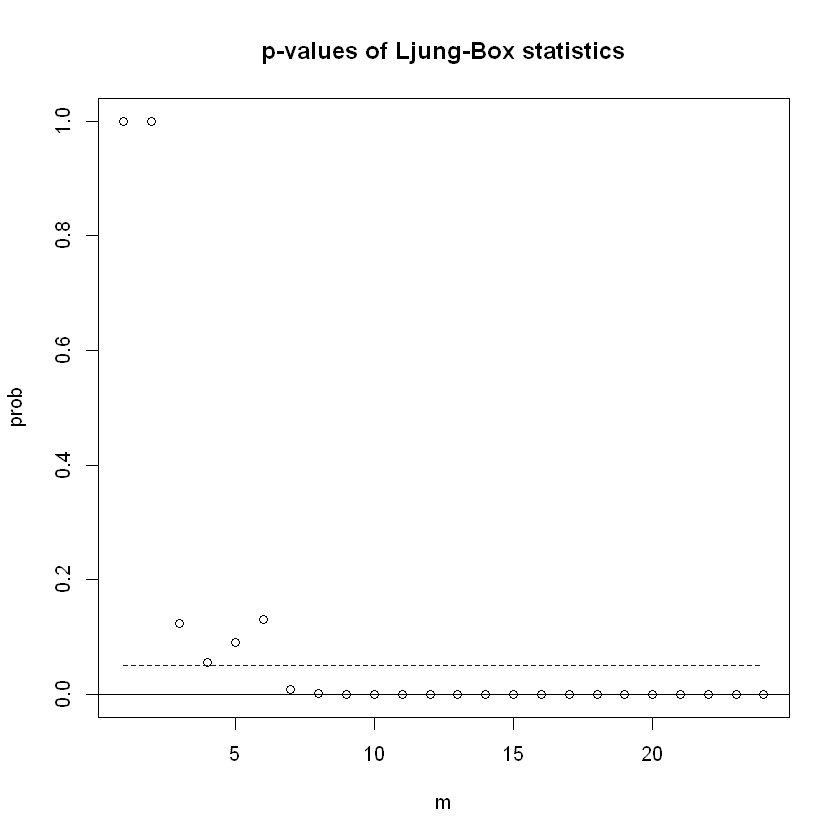

In [23]:
#Modelo check:
resi3=m3_mts$residuals
mq(resi3, adj=19) #Ajustamos los grados de libertad

En la prueba Ljung-box hay may rezagos (hasta el rezago 6) encima del umbral de significancia, Esto indica que los residuos del modelo están autocorrelacionados a rezagos más altos, lo que sugiere que se deberia utilizar un VAR incluso mayor, ya que hay estructura no capturada como no linealidad, heterocedasticidad, entre otros, o que otro modelo como VECM podria ajustarse mejor

[1] "Covariance matrix:"
       ryld   tsla    tm    gm
ryld 0.0692  0.799 0.291 0.162
tsla 0.7986 65.972 4.924 2.743
tm   0.2914  4.924 5.206 1.248
gm   0.1620  2.743 1.248 1.174
CCM at lag:  0 
      [,1]  [,2]  [,3]  [,4]
[1,] 1.000 0.374 0.486 0.568
[2,] 0.374 1.000 0.266 0.312
[3,] 0.486 0.266 1.000 0.505
[4,] 0.568 0.312 0.505 1.000
Simplified matrix: 
CCM at lag:  1 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  2 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  3 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  4 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  5 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  6 
- . . - 
. . . . 
. . . . 
. . . . 
CCM at lag:  7 
+ + . + 
. + . . 
. . . . 
. . . + 
CCM at lag:  8 
. . . - 
. - . . 
. . . - 
. . . - 
CCM at lag:  9 
+ + . . 
. + . + 
. . . . 
+ . . . 
CCM at lag:  10 
. . . . 
. . . . 
. . - . 
. . - . 
CCM at lag:  11 
. . . . 
. . . + 
. . . . 
. . . . 
CCM at lag:  12 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag: 

Hit Enter for p-value plot of individual ccm:  


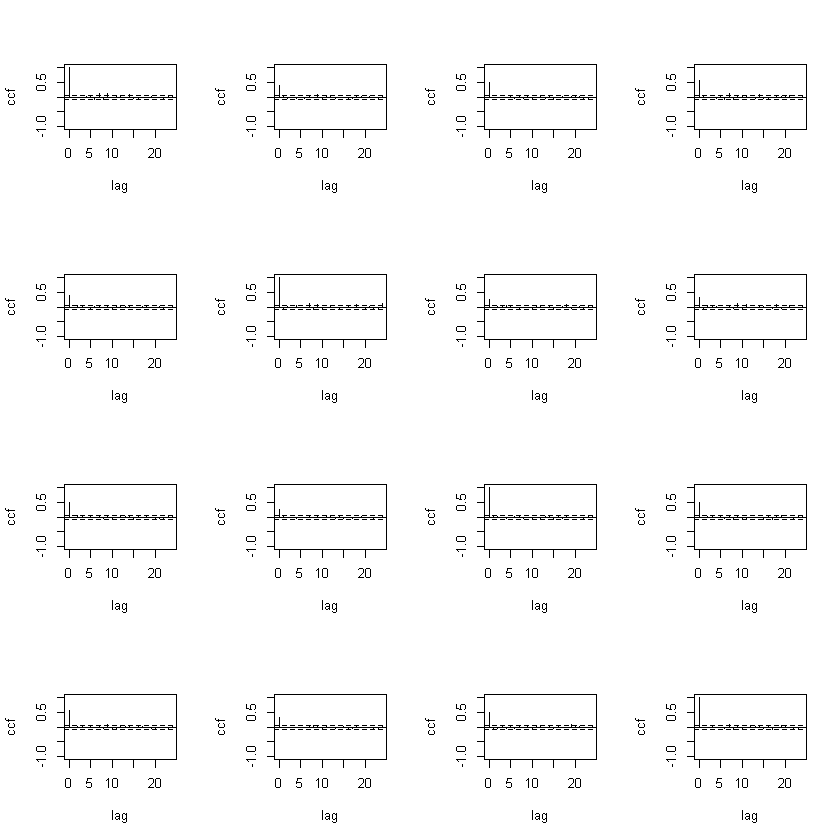

Hit Enter to compute MQ-statistics: 
Ljung-Box Statistics:  
        m       Q(m)     df    p-value
 [1,]   1.0      16.6    -3.0     1.00
 [2,]   2.0      33.4    13.0     1.00
 [3,]   3.0      37.9    29.0     0.12
 [4,]   4.0      60.9    45.0     0.06
 [5,]   5.0      76.1    61.0     0.09
 [6,]   6.0      91.0    77.0     0.13
 [7,]   7.0     128.6    93.0     0.01
 [8,]   8.0     155.3   109.0     0.00
 [9,]   9.0     196.3   125.0     0.00
[10,]  10.0     213.3   141.0     0.00
[11,]  11.0     236.4   157.0     0.00
[12,]  12.0     248.3   173.0     0.00
[13,]  13.0     260.6   189.0     0.00
[14,]  14.0     288.9   205.0     0.00
[15,]  15.0     312.5   221.0     0.00
[16,]  16.0     328.3   237.0     0.00
[17,]  17.0     354.3   253.0     0.00
[18,]  18.0     376.7   269.0     0.00
[19,]  19.0     418.2   285.0     0.00
[20,]  20.0     425.7   301.0     0.00
[21,]  21.0     444.2   317.0     0.00
[22,]  22.0     459.4   333.0     0.00
[23,]  23.0     480.3   349.0     0.00
[24

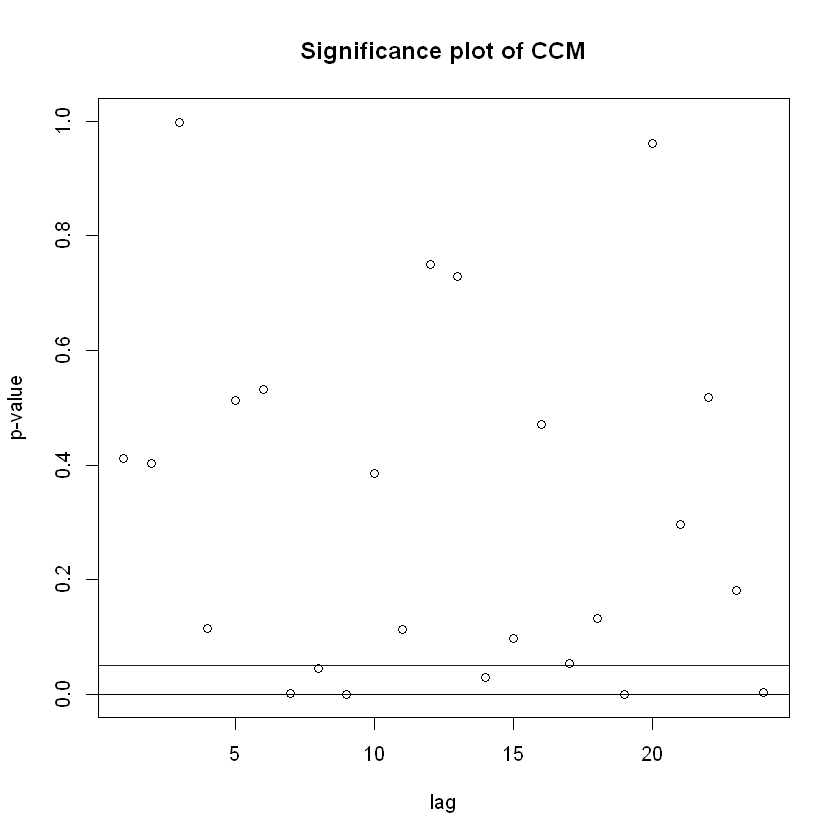

Hit Enter to obtain residual plots: 


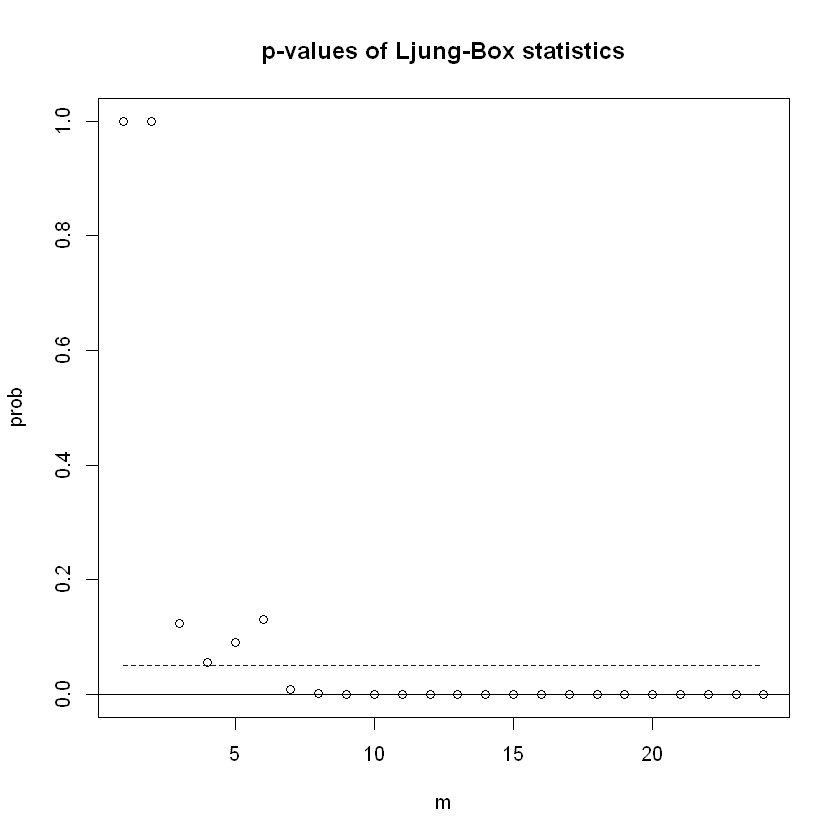

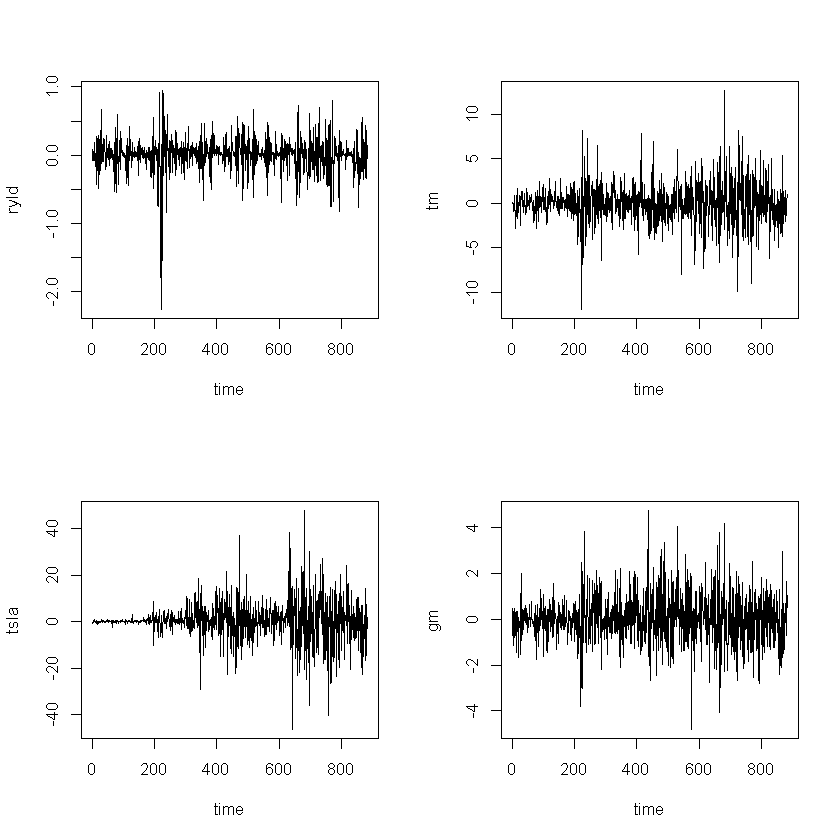

In [24]:
#Y revisamos el efecto instantáneo entre las variables:
MTSdiag(m3_mts, adj=19) 

##### Pronóstico

orig  886 
Forecasts at origin:  886 
       ryld  tsla    tm    gm
 [1,] 19.24 211.2 135.4 35.78
 [2,] 19.17 211.2 135.6 35.81
 [3,] 19.19 211.1 135.9 35.87
 [4,] 19.16 211.1 136.1 35.88
 [5,] 19.16 211.1 136.3 35.92
 [6,] 19.14 211.0 136.5 35.94
 [7,] 19.14 211.0 136.7 35.97
 [8,] 19.13 210.9 136.9 35.98
 [9,] 19.12 210.9 137.1 36.00
[10,] 19.11 210.9 137.3 36.02
[11,] 19.11 210.8 137.5 36.03
[12,] 19.10 210.8 137.7 36.04
[13,] 19.09 210.7 137.8 36.05
[14,] 19.08 210.7 138.0 36.05
[15,] 19.08 210.7 138.2 36.06
[16,] 19.07 210.6 138.4 36.06
[17,] 19.06 210.6 138.5 36.06
[18,] 19.05 210.5 138.7 36.05
[19,] 19.05 210.5 138.8 36.05
[20,] 19.04 210.5 139.0 36.04
[21,] 19.03 210.4 139.2 36.03
[22,] 19.03 210.4 139.3 36.02
[23,] 19.02 210.4 139.5 36.01
[24,] 19.01 210.3 139.6 35.99
[25,] 19.01 210.3 139.7 35.98
[26,] 19.00 210.2 139.9 35.96
[27,] 18.99 210.2 140.0 35.94
[28,] 18.99 210.2 140.1 35.92
[29,] 18.98 210.1 140.3 35.90
[30,] 18.97 210.1 140.4 35.87
[31,] 18.97 210.0 140.5 35.85
[3

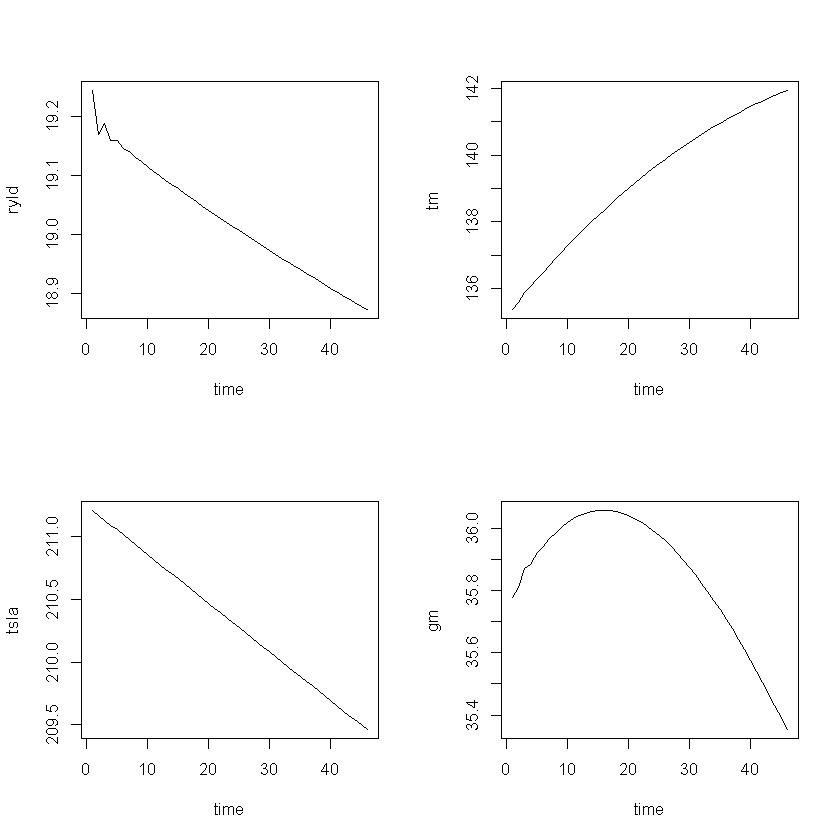

In [25]:
#Podemos visualizar los pronósticos a través de la función VARpred().
library(forecast)
pred2=VARpred(m3_mts,  h=46) # Pasos a pronosticar (12)
MTSplot(pred2$pred)

## Modelo VAR con diferenciación

### **Diferenciación**

In [26]:
#Comenzamos diferenciando los activos para luego, unirlos.
ryld.d=diff.xts(s1$RYLD.Close)[-1,]
tsla.d=diff.xts(s2$TSLA.Close)[-1,]
tm.d= diff.xts(i3$TM.Close)[-1,]
gm.d= diff.xts(i4$GM.Close)[-1,]

In [27]:
# Pruebas de estacionalidad
adf.test(ryld.d)
adf.test(tsla.d)
adf.test(tm.d)
adf.test(gm.d)


	Augmented Dickey-Fuller Test

data:  ryld.d
Dickey-Fuller = -8.0814, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  tsla.d
Dickey-Fuller = -9.2478, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  tm.d
Dickey-Fuller = -10.768, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  gm.d
Dickey-Fuller = -9.895, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


Ya con la primera diferenciación, las series son estacionarias, y no es necesario diferenciarlas más.

In [28]:
#Pasamos a formato ts
ryld.d.ts=ts(ryld.d, start= c(2019,04,22), frequency = 365)
tsla.d.ts= ts(tsla.d, start= c(2019,04,22), frequency = 365)
tm.d.ts=ts(tm.d, start= c(2019,04,22), frequency = 365)
gm.d.ts=ts(gm.d, start= c(2019,04,22), frequency = 365)

In [29]:
# Y unimos:
dataVAR3=ts.intersect(ryld.d.ts, tsla.d.ts, tm.d.ts, gm.d.ts) %>% na.omit()
#dataVAR3

#### Partición de los datos

In [30]:
n <- nrow(dataVAR3)
n_test <- 47 #Equivalente al 5%
n_test
n_train <- n - n_test
n_train
train_dif <- dataVAR3[1:n_train, ]
test_dif <- dataVAR3[(n_train + 1):n, ]

[1] 47

[1] 885

##### Nivel K Selection

In [31]:
#Nuevamente, seleccionamos nivel autorregresivo:
nivelk3=VARselect(train_dif, lag.max = 7, type = "const")
nivelk3$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      2      1      2

Se elige que el nivel autoregresivo es 2, por lo que a continuación se pone K=2

##### Johansen Test

In [32]:
#Podemos aplicar prueba Johansen test para verificar si hay estabilidad a largo plazo.
johatest=ca.jo(train_dif, type = "trace", K=2, ecdet ="none", spec = "longrun") #K is the number of lags to use in the vector autoregressive model and is set this to the minimum, K=2.
summary(johatest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.3567214 0.3396544 0.3166050 0.2624927

Values of teststatistic and critical values of test:

            test 10pct  5pct  1pct
r <= 3 |  268.86  6.50  8.18 11.65
r <= 2 |  605.00 15.66 17.95 23.52
r <= 1 |  971.44 28.71 31.52 37.22
r = 0  | 1361.00 45.23 48.28 55.43

Eigenvectors, normalised to first column:
(These are the cointegration relations)

             ryld.d.ts.l2 tsla.d.ts.l2 tm.d.ts.l2  gm.d.ts.l2
ryld.d.ts.l2   1.00000000     1.000000  1.0000000  1.00000000
tsla.d.ts.l2  -0.03204476     1.879683 -0.1003516 -0.00348410
tm.d.ts.l2     0.08215704    -1.851224 -1.4732331 -0.02554770
gm.d.ts.l2    -0.60291677    -8.109574  0.9661581 -0.04329491

Weights W:
(This is the loading matrix)

            ryld.d.ts.l2  tsla.d.ts.l2 tm.d.ts.l2 gm.d.ts.l2
ryld.d.ts.d    0.1145006  0.0003723644 0.02450919 -0.9942444
tsla.d.ts.d    7.830915

con r=0 y valor de 1361, parece que todas las series estuvieran cointegradas, pero no es que lo estén sino que todas las series van al unisono porque se achataron con la diferenciación -> Sin embargo, se observa que están con un equilibrio a largo plazo

### Modelo con libreria vars y series diferenciadas

In [33]:
#Armamos modelo VAR
var_dif_libvars <- vars::VAR(y=train_dif, p=2) #K=2
summary(var_dif_libvars)


VAR Estimation Results:
Endogenous variables: ryld.d.ts, tsla.d.ts, tm.d.ts, gm.d.ts 
Deterministic variables: const 
Sample size: 883 
Log Likelihood: -6062.921 
Roots of the characteristic polynomial:
0.5707 0.4178 0.2799 0.2799 0.2761 0.2761 0.1395 0.09844
Call:
vars::VAR(y = train_dif, p = 2)


Estimation results for equation ryld.d.ts: 
ryld.d.ts = ryld.d.ts.l1 + tsla.d.ts.l1 + tm.d.ts.l1 + gm.d.ts.l1 + ryld.d.ts.l2 + tsla.d.ts.l2 + tm.d.ts.l2 + gm.d.ts.l2 + const 

               Estimate Std. Error t value Pr(>|t|)    
ryld.d.ts.l1 -0.1404907  0.0427211  -3.289  0.00105 ** 
tsla.d.ts.l1  0.0003732  0.0011952   0.312  0.75490    
tm.d.ts.l1   -0.0017988  0.0046631  -0.386  0.69977    
gm.d.ts.l1    0.0152832  0.0104306   1.465  0.14322    
ryld.d.ts.l2  0.2856285  0.0428700   6.663 4.75e-11 ***
tsla.d.ts.l2 -0.0023379  0.0011954  -1.956  0.05081 .  
tm.d.ts.l2   -0.0001906  0.0046566  -0.041  0.96736    
gm.d.ts.l2   -0.0206117  0.0104105  -1.980  0.04803 *  
const        -0.005

**Observaciones**
Con una significancia del 5%:
- RYLD se explica con su primer y segundo rezago, y con el segundo rezago de GM.
- No hay rezagos que expliquen a TSLA significativamente
- TM se explica con el primer rezago de RYLD
- GM se explica con el primer rezago de TSLA, y el segundo rezago de RYLD

#### Función de impulso respuesta

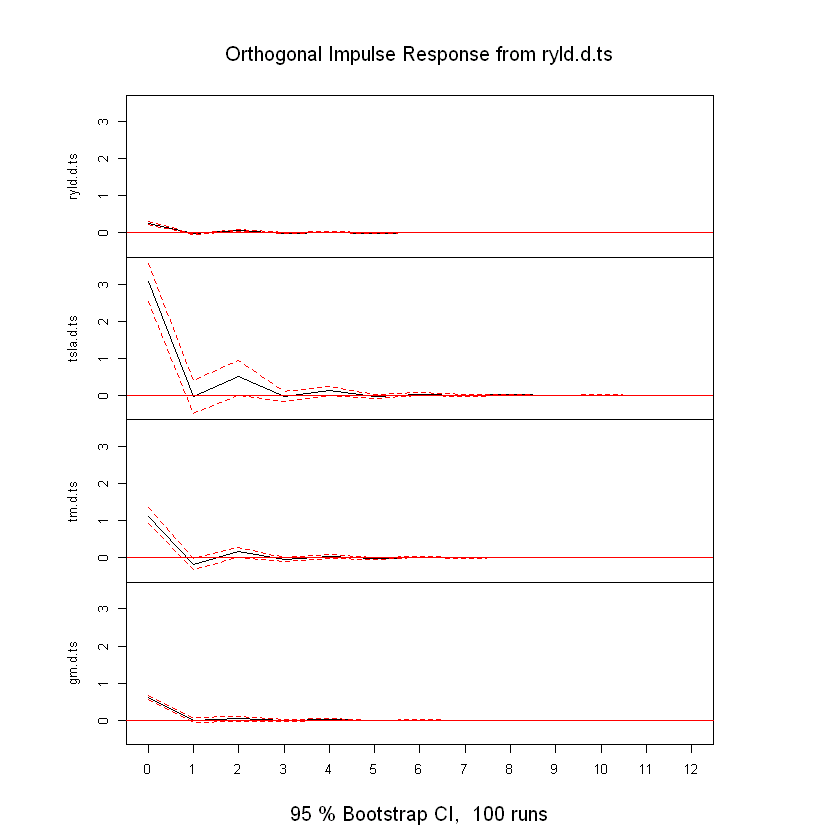

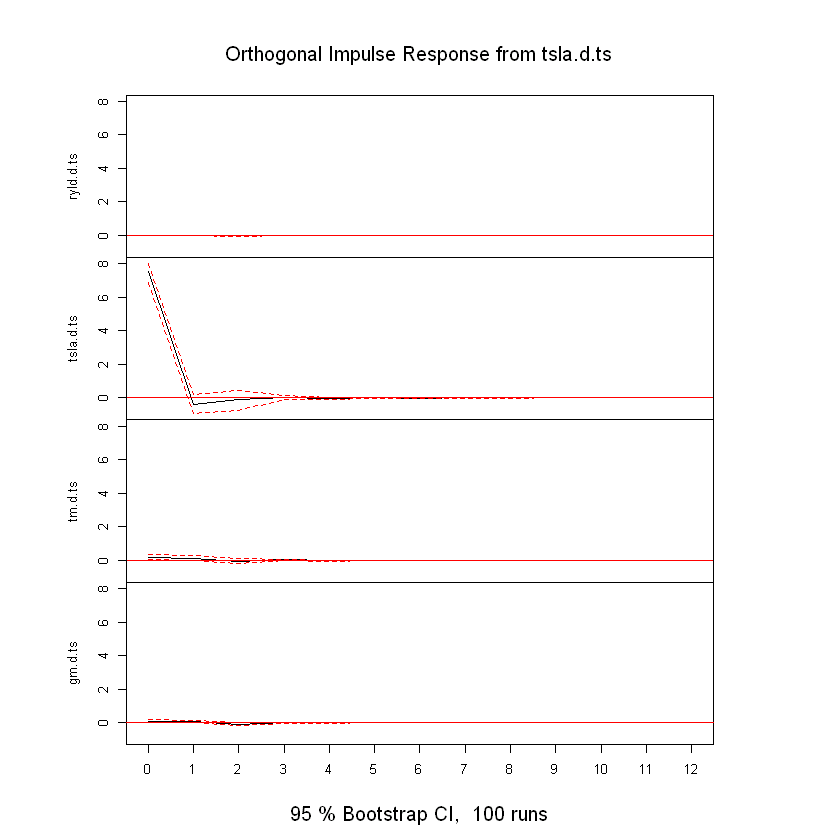

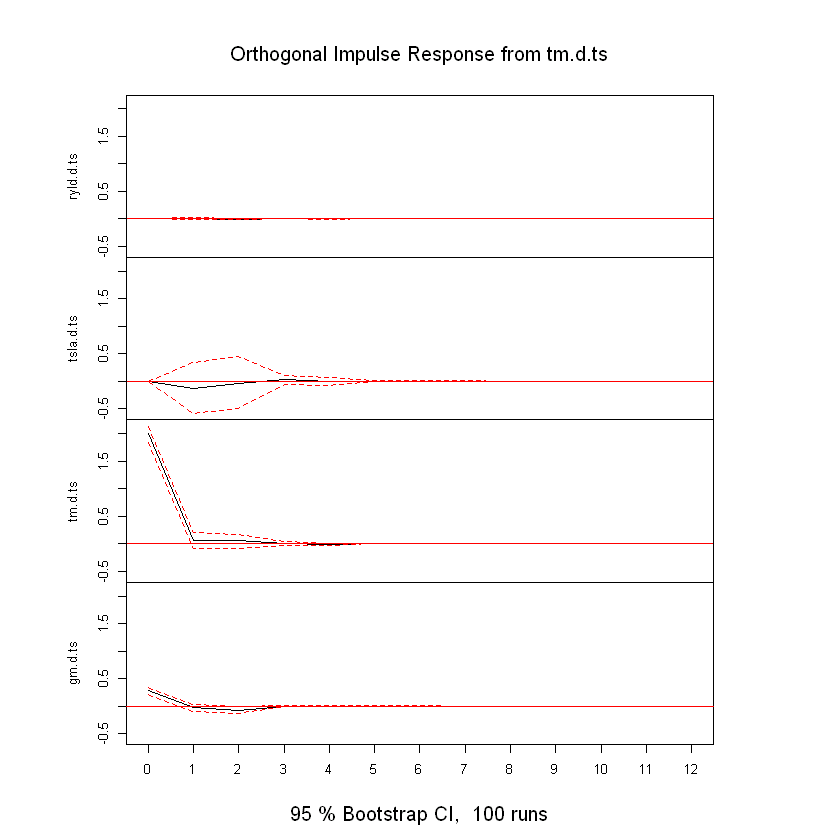

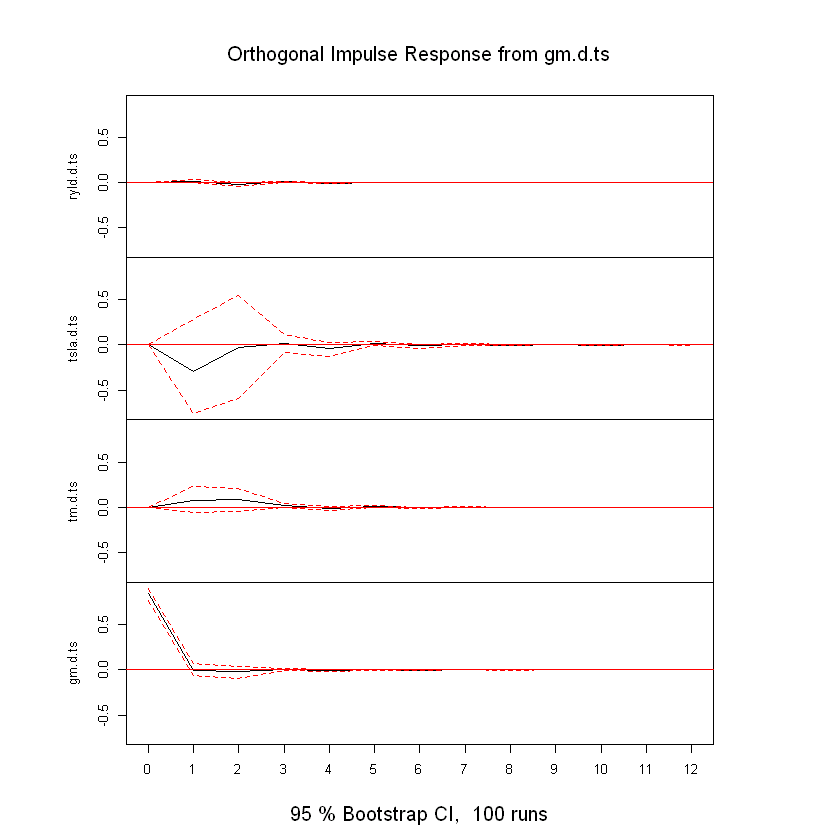

In [70]:
# Aplicamos la función irf al modelo VAR, de la paquetería vars donde los datos eran estacionarios.
m1irf = irf(var_dif_libvars, n.ahead = 12, boot = TRUE)
plot(m1irf) 

### Pronostico: Libreria vars y series diferenciadas

In [34]:
libvars_predtest=predict(var_dif_libvars, n.ahead=47)

#### Recover level forecast

In [35]:
#Como diferenciamos, recuperamos el nivel.
nhor=46 #pasos en el pronóstico.
nr_lev <- nrow(train)
mr_lev= as.matrix(train)
str(mr_lev)
m.varf_lev_ft <- rbind(mr_lev, matrix(NA, nhor,4 )) #No variables
m.ft_df <- do.call(cbind,lapply(libvars_predtest$fcst, 
                                function(x) x[,"fcst"]))

 num [1:886, 1:4] 25 25.2 25.2 25.1 25.2 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:886] "2019-04-22" "2019-04-23" "2019-04-24" "2019-04-25" ...
  ..$ : chr [1:4] "RYLD" "TSLA" "TM" "GM"


#### Growth to level

In [36]:
for(h in (nr_lev+1):(nr_lev+nhor)) {
  hf <- h - nr_lev
  m.varf_lev_ft[h,] <- m.varf_lev_ft[h-1,] + m.ft_df[hf,]
}

#### Draw Graph

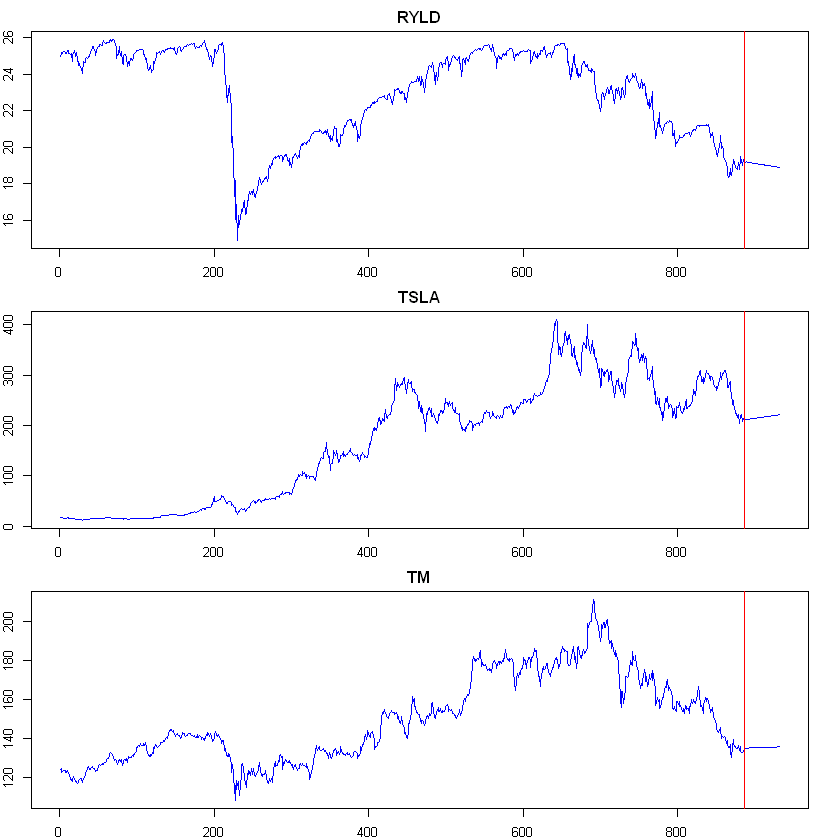

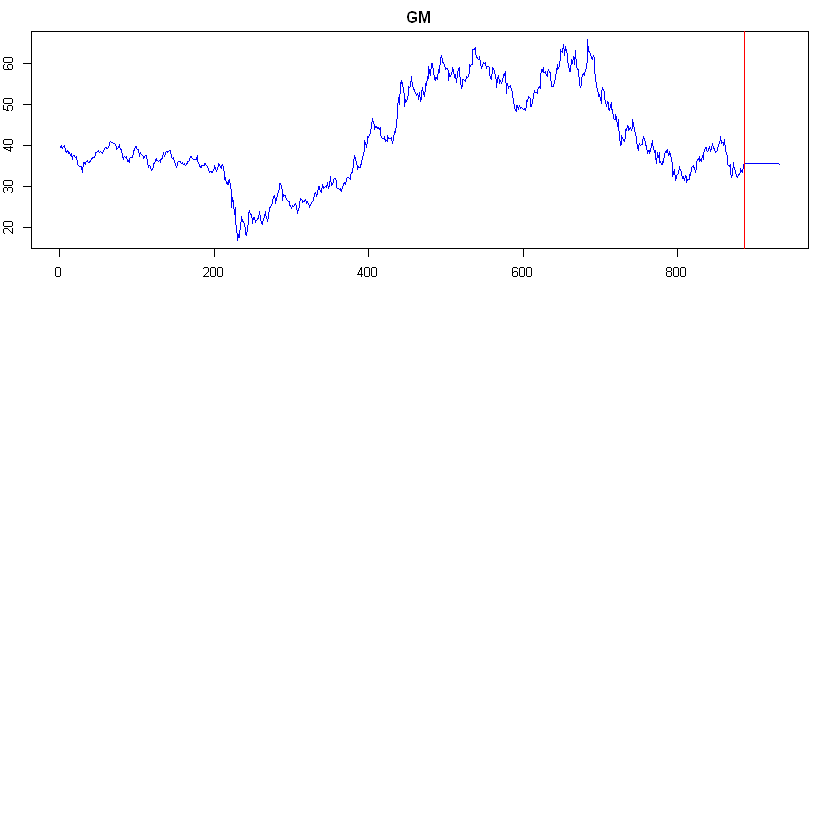

In [37]:
str.main=c("RYLD", "TSLA", "TM", "GM")
par(mfrow=c(3,1), mar=c(2,2,2,2))

for(i in 1:4) {
  df <- m.varf_lev_ft[,i]
  matplot(df, type=c("l"), col = c("blue"), 
          main = str.main[i]) 
  abline(v=nr_lev, col="red")
}

In [38]:
# Extraigo los 46 valores que pronostico ya con el nivel recuperado
libvars_predtest_lvl <- tail(m.varf_lev_ft, 47)

#### Métricas de desempeño

In [39]:
library(Metrics)

variables <- colnames(test)

rsq <- function(actual, predicted) {
  1 - sum((actual - predicted)^2) / sum((actual - mean(actual))^2)
}

for (v in variables) {
  cat("Variable:", v, "\n")
  cat("MAPE:", mape(actual = test[, v], predicted = libvars_predtest_lvl[, v]), "\n")
  cat("RMSE:", rmse(actual = test[, v], predicted = libvars_predtest_lvl[, v]), "\n")
  cat("MAE :", mae(actual = test[, v], predicted = libvars_predtest_lvl[, v]), "\n")
  cat("R²  :", rsq(actual = test[, v], predicted = libvars_predtest_lvl[, v]), "\n\n")
}


Variable: RYLD 
MAPE: 0.01636031 
RMSE: 0.3698066 
MAE : 0.318948 
R²  : -0.5878642 

Variable: TSLA 
MAPE: 0.2821014 
RMSE: 51.67979 
MAE : 42.33578 
R²  : -1.657756 

Variable: TM 
MAPE: 0.03750074 
RMSE: 6.559112 
MAE : 5.37977 
R²  : -1.76465 

Variable: GM 
MAPE: 0.07897345 
RMSE: 3.316087 
MAE : 3.054765 
R²  : -1.310598 



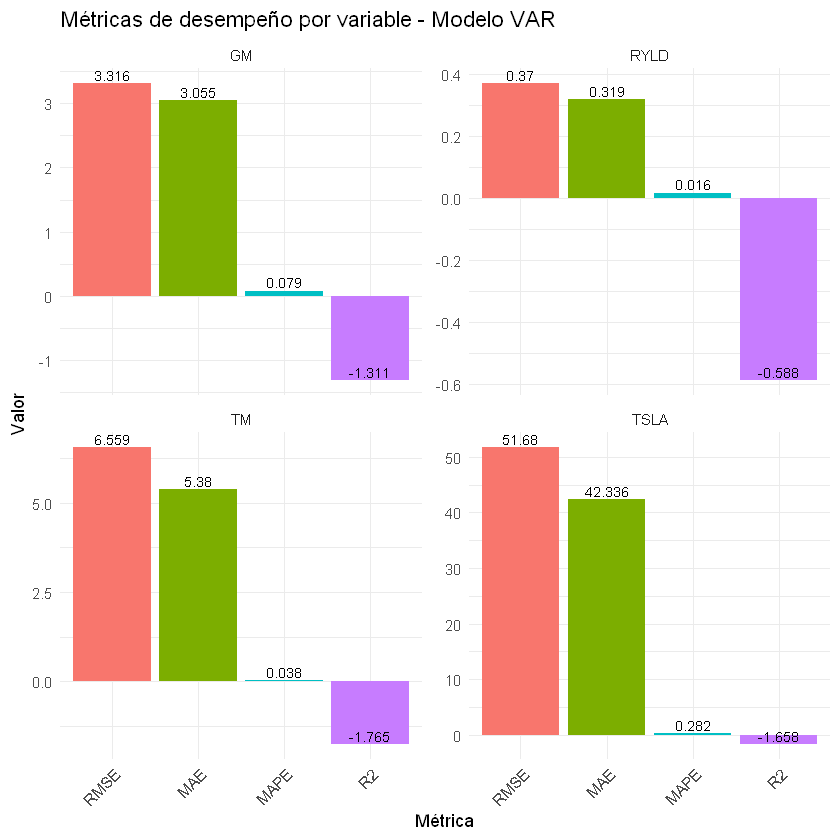

In [42]:
library(Metrics)
library(ggplot2)
library(dplyr)
library(tidyr)

rsq <- function(actual, predicted) {
  1 - sum((actual - predicted)^2) / sum((actual - mean(actual))^2)
}

variables <- colnames(test)

metricas_df <- data.frame()

for (v in variables) {
  mape_val <- mape(actual = test[, v], predicted = libvars_predtest_lvl[, v])
  rmse_val <- rmse(actual = test[, v], predicted = libvars_predtest_lvl[, v])
  mae_val  <- mae(actual = test[, v], predicted = libvars_predtest_lvl[, v])
  rsq_val  <- rsq(actual = test[, v], predicted = libvars_predtest_lvl[, v])
  
  temp_df <- data.frame(
    Variable = v,
    Metrica = c("RMSE", "MAE", "MAPE", "R2"),
    Valor = c(rmse_val, mae_val, mape_val, rsq_val)
  )
  
  metricas_df <- rbind(metricas_df, temp_df)
}

# Convertir métrica en factor para orden en el gráfico
metricas_df$Metrica <- factor(metricas_df$Metrica, levels = c("RMSE", "MAE", "MAPE", "R2"))

# Gráfico por variable con barras para cada métrica
ggplot(metricas_df, aes(x = Metrica, y = Valor, fill = Metrica)) +
  geom_col() +
  geom_text(aes(label = round(Valor, 3)), vjust = -0.3, size = 3) +
  facet_wrap(~ Variable, scales = "free_y") +
  labs(title = "Métricas de desempeño por variable - Modelo VAR",
       y = "Valor",
       x = "Métrica") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none")



## Pronostico hacia adelante

In [51]:
var_dif_libvars <- vars::VAR(y=dataVAR3, p=2) #K=2

In [52]:
libvars_predtest=predict(var_dif_libvars, n.ahead=10)

In [53]:
#Como diferenciamos, recuperamos el nivel.
nhor=10 #pasos en el pronóstico.
nr_lev <- nrow(train)
mr_lev= as.matrix(train)
str(mr_lev)
m.varf_lev_ft <- rbind(mr_lev, matrix(NA, nhor,4 )) #No variables
m.ft_df <- do.call(cbind,lapply(libvars_predtest$fcst, 
                                function(x) x[,"fcst"]))

 num [1:886, 1:4] 25 25.2 25.2 25.1 25.2 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:886] "2019-04-22" "2019-04-23" "2019-04-24" "2019-04-25" ...
  ..$ : chr [1:4] "RYLD" "TSLA" "TM" "GM"


In [54]:
for(h in (nr_lev+1):(nr_lev+nhor)) {
  hf <- h - nr_lev
  m.varf_lev_ft[h,] <- m.varf_lev_ft[h-1,] + m.ft_df[hf,]
}

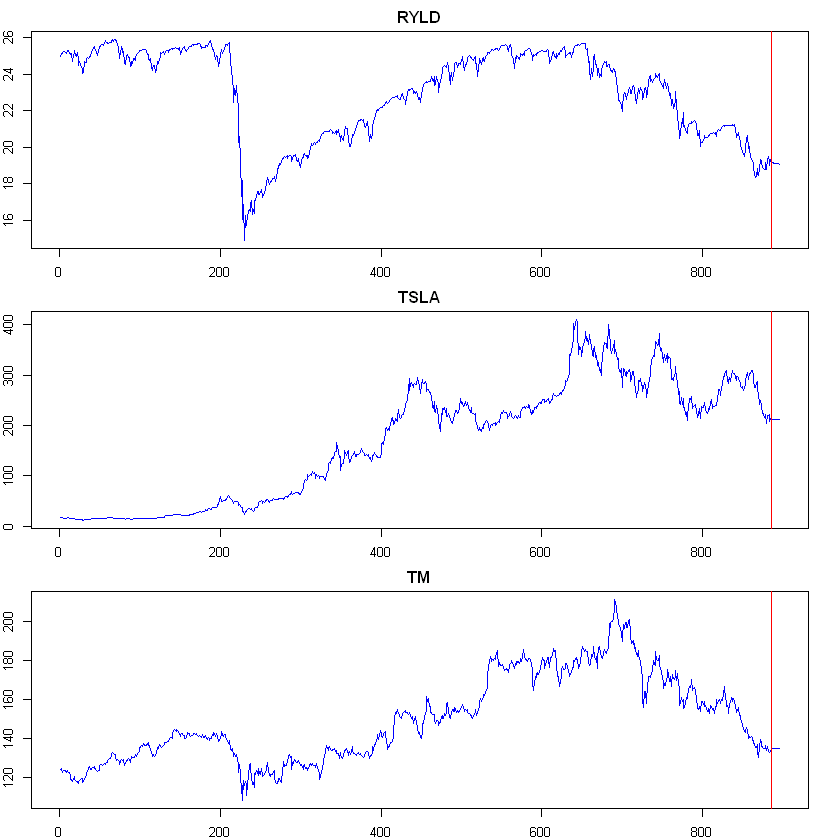

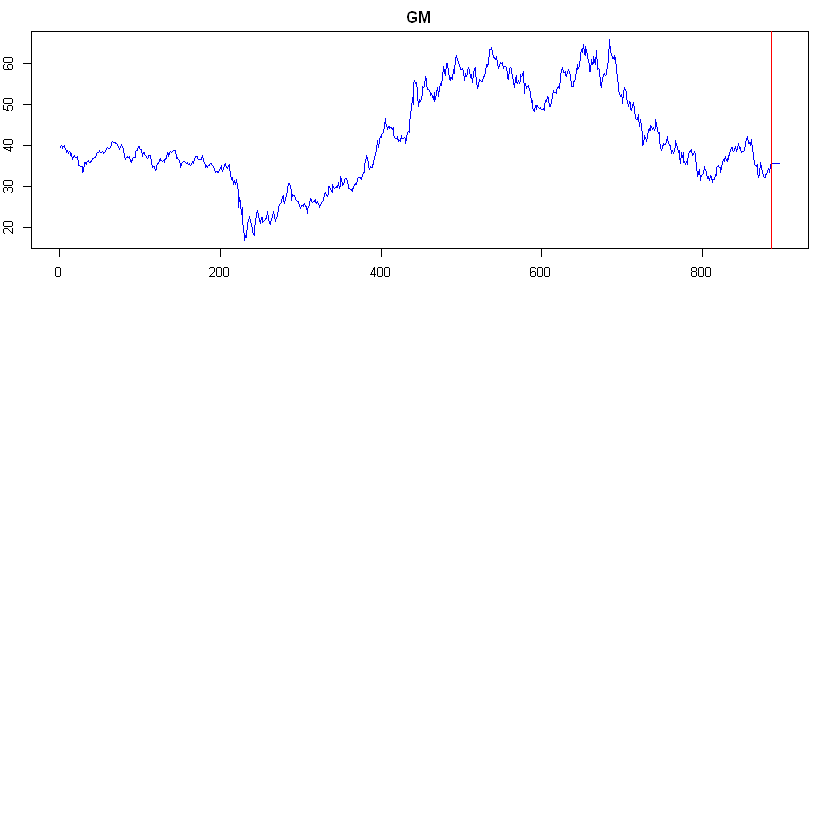

In [55]:
str.main=c("RYLD", "TSLA", "TM", "GM")
par(mfrow=c(3,1), mar=c(2,2,2,2))

for(i in 1:4) {
  df <- m.varf_lev_ft[,i]
  matplot(df, type=c("l"), col = c("blue"), 
          main = str.main[i]) 
  abline(v=nr_lev, col="red")
}

In [56]:
libvars_predtest_lvl <- tail(m.varf_lev_ft, 10)
libvars_predtest_lvl

,RYLD,TSLA,TM,GM
,19.15517,211.3251,134.9003,35.56303
,19.13978,211.4527,134.8947,35.56621
,19.13219,211.5067,134.8968,35.54978
,19.12265,211.6079,134.9098,35.53949
,19.11614,211.7187,134.9259,35.53347
,19.10852,211.8267,134.9395,35.52565
,19.10175,211.9404,134.9551,35.51894
,19.09462,212.0522,134.9696,35.51187
,19.08774,212.1656,134.9847,35.50504
,19.08074,212.2783,134.9994,35.49812


### Modelo con libreria MTS y series diferenciadas

In [77]:
m3=VARorder(train_dif) 

selected order: aic =  2 
selected order: bic =  0 
selected order: hq =  2 
Summary table:  
       p    AIC    BIC     HQ    M(p) p-value
 [1,]  0 2.5661 2.5661 2.5661  0.0000  0.0000
 [2,]  1 2.5449 2.6314 2.5780 49.7083  0.0000
 [3,]  2 2.4953 2.6684 2.5615 73.9426  0.0000
 [4,]  3 2.5222 2.7818 2.6215  7.9571  0.9501
 [5,]  4 2.5303 2.8764 2.6626 24.0192  0.0891
 [6,]  5 2.5446 2.9772 2.7100 18.5593  0.2922
 [7,]  6 2.5595 3.0786 2.7580 18.0183  0.3228
 [8,]  7 2.5537 3.1593 2.7852 35.3461  0.0036
 [9,]  8 2.5613 3.2535 2.8259 23.9211  0.0912
[10,]  9 2.5573 3.3360 2.8550 33.5402  0.0063
[11,] 10 2.5694 3.4346 2.9002 19.9465  0.2226
[12,] 11 2.5765 3.5282 2.9403 24.0472  0.0885
[13,] 12 2.5973 3.6355 2.9942 12.6425  0.6987
[14,] 13 2.6195 3.7443 3.0495 11.3889  0.7849


También se obtiene un nivel de 2

In [78]:
m3_mts=MTS::VAR(train_dif, 2)

Constant term: 
Estimates:  -0.005413425 0.2545003 0.007388606 -0.001985235 
Std.Error:  0.008886438 0.2742414 0.07765216 0.03683012 
AR coefficient matrix 
AR( 1 )-matrix 
        [,1]      [,2]    [,3]     [,4]
[1,] -0.1405  0.000373 -0.0018  0.01528
[2,]  1.2525 -0.043873 -0.0131 -0.35200
[3,] -1.0907  0.014009  0.0122  0.09280
[4,] -0.0555  0.009925 -0.0102 -0.00975
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0427 0.00120 0.00466 0.0104
[2,] 1.3184 0.03688 0.14391 0.3219
[3,] 0.3733 0.01044 0.04075 0.0911
[4,] 0.1771 0.00495 0.01933 0.0432
AR( 2 )-matrix 
      [,1]     [,2]      [,3]    [,4]
[1,] 0.286 -0.00234 -0.000191 -0.0206
[2,] 2.394 -0.01228 -0.016173 -0.0696
[3,] 0.243 -0.00693  0.012395  0.1269
[4,] 0.442 -0.00867 -0.032857 -0.0179
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0429 0.00120 0.00466 0.0104
[2,] 1.3230 0.03689 0.14371 0.3213
[3,] 0.3746 0.01045 0.04069 0.0910
[4,] 0.1777 0.00495 0.01930 0.0431
  
Residuals cov-mtx: 
           [,1] 

**Se analiza la estacionalidad**

In [79]:
str(m3_mts)

List of 13
 $ data     : num [1:885, 1:4] 0.162 0.032 -0.059 0.095 0.025 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "ryld.d.ts" "tsla.d.ts" "tm.d.ts" "gm.d.ts"
 $ cnst     : logi TRUE
 $ order    : num 2
 $ coef     : num [1:9, 1:4] -0.005413 -0.140491 0.000373 -0.001799 0.015283 ...
 $ aic      : num 2.45
 $ bic      : num 2.63
 $ hq       : num 2.52
 $ residuals: num [1:883, 1:4] -0.0901 0.0897 0.0388 -0.0522 -0.0705 ...
 $ secoef   : num [1:9, 1:4] 0.00889 0.04272 0.0012 0.00466 0.01043 ...
 $ Sigma    : num [1:4, 1:4] 0.0687 0.8016 0.2933 0.1611 0.8016 ...
 $ Phi      : num [1:4, 1:8] -0.140491 1.25252 -1.090654 -0.055505 0.000373 ...
 $ Ph0      : num [1:4] -0.00541 0.2545 0.00739 -0.00199
 $ fixed    : NULL


In [80]:
phi1=m3_mts$Phi[,c(1,2,3,4)] #AR(1)
phi2=m3_mts$Phi[,c(5,6,7,8)] #AR(2)
phi1
phi2

-0.1404907,0.0003732345,-0.00179880,0.015283163
1.2525200,-0.0438732655,-0.01308319,-0.351999823
-1.0906540,0.0140094712,0.01220346,0.092795412
-0.0555048,0.0099249692,-0.01022899,-0.009745621


0.2856285,-0.002337941,-0.0001905935,-0.02061174
2.3936355,-0.012275556,-0.0161727385,-0.06961616
0.2429462,-0.006929522,0.0123948971,0.12692374
0.4421060,-0.008667257,-0.0328572185,-0.01792375


In [81]:
#Descomposición de valores singulares
eigen(phi1) 
eigen(phi2)

eigen() decomposition
$values
[1] -0.13131289+0.0000000i -0.03908925+0.0512035i -0.03908925-0.0512035i
[4]  0.02758529+0.0000000i

$vectors
               [,1]                    [,2]                    [,3]
[1,]  0.09942436+0i -0.01074075-0.02049658i -0.01074075+0.02049658i
[2,] -0.67072918+0i  0.93462308+0.00000000i  0.93462308+0.00000000i
[3,]  0.71726884+0i -0.16468012-0.23834030i -0.16468012+0.23834030i
[4,]  0.16050726+0i -0.04480032-0.20002879i -0.04480032+0.20002879i
               [,4]
[1,]  0.02517569+0i
[2,] -0.21483623+0i
[3,] -0.96159864+0i
[4,]  0.16893678+0i


eigen() decomposition
$values
[1] 0.238821635+0.00000000i 0.007484499+0.07601142i 0.007484499-0.07601142i
[4] 0.014033430+0.00000000i

$vectors
              [,1]                     [,2]                     [,3]
[1,] -0.1069278+0i  0.002971995-0.02991338i  0.002971995+0.02991338i
[2,] -0.9727854+0i -0.503574448-0.37591664i -0.503574448+0.37591664i
[3,] -0.1583986+0i -0.682478528+0.00000000i -0.682478528+0.00000000i
[4,] -0.1310150+0i -0.006778275-0.37198511i -0.006778275+0.37198511i
               [,4]
[1,] -0.01079383+0i
[2,] -0.98870521+0i
[3,]  0.14614217+0i
[4,] -0.03143207+0i


Se observa que los valores propios son apropiados

#### Modelo VAR refinado y con diferenciación

In [82]:
m4_mts=refVAR(m3_mts,thres = 1.96) 

Constant term: 
Estimates:  0 0 0 0 
Std.Error:  0 0 0 0 
AR coefficient matrix 
AR( 1 )-matrix 
       [,1] [,2] [,3] [,4]
[1,] -0.110    0    0    0
[2,]  0.000    0    0    0
[3,] -0.712    0    0    0
[4,]  0.000    0    0    0
standard error 
       [,1] [,2] [,3] [,4]
[1,] 0.0329    0    0    0
[2,] 0.0000    0    0    0
[3,] 0.2832    0    0    0
[4,] 0.0000    0    0    0
AR( 2 )-matrix 
      [,1]     [,2]    [,3]    [,4]
[1,] 0.272  0.00000  0.0000 -0.0243
[2,] 0.000  0.00000  0.0000  0.0000
[3,] 0.000  0.00000  0.0000  0.1554
[4,] 0.439 -0.00962 -0.0361  0.0000
standard error 
       [,1]   [,2]   [,3]    [,4]
[1,] 0.0396 0.0000 0.0000 0.00979
[2,] 0.0000 0.0000 0.0000 0.00000
[3,] 0.0000 0.0000 0.0000 0.07076
[4,] 0.1612 0.0049 0.0183 0.00000
  
Residuals cov-mtx: 
                      resi                    
     0.06916046  0.7964633 0.2955452 0.1612436
resi 0.79646333 65.9615077 4.8661707 2.6771854
     0.29554517  4.8661707 5.2722566 1.2711235
     0.16124361  2.67718

**Se checa el modelo**

Ljung-Box Statistics:  
        m       Q(m)     df    p-value
 [1,]   1.0      17.8     8.0     1.00
 [2,]   2.0      29.5    24.0     0.20
 [3,]   3.0      35.0    40.0     0.70
 [4,]   4.0      61.1    56.0     0.30
 [5,]   5.0      76.7    72.0     0.33
 [6,]   6.0      92.3    88.0     0.36
 [7,]   7.0     127.5   104.0     0.06
 [8,]   8.0     157.3   120.0     0.01
 [9,]   9.0     199.8   136.0     0.00
[10,]  10.0     216.8   152.0     0.00
[11,]  11.0     236.4   168.0     0.00
[12,]  12.0     248.0   184.0     0.00
[13,]  13.0     260.6   200.0     0.00
[14,]  14.0     284.8   216.0     0.00
[15,]  15.0     309.6   232.0     0.00
[16,]  16.0     327.2   248.0     0.00
[17,]  17.0     352.2   264.0     0.00
[18,]  18.0     373.5   280.0     0.00
[19,]  19.0     417.2   296.0     0.00
[20,]  20.0     425.9   312.0     0.00
[21,]  21.0     439.9   328.0     0.00
[22,]  22.0     452.4   344.0     0.00
[23,]  23.0     472.4   360.0     0.00
[24,]  24.0     507.7   376.0     0.00


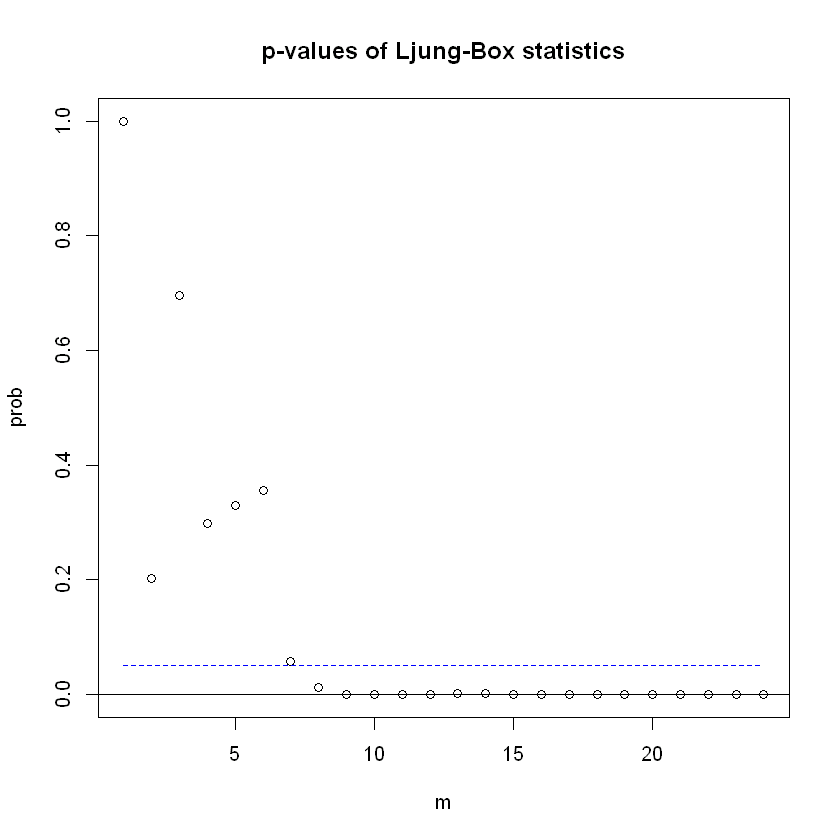

In [88]:
#Modelo check:
resi4=m4_mts$residuals
mq(resi4, adj=8) #Ajustamos los grados de libertad

En la prueba Ljung-box hay may rezagos (hasta el rezago 7) encima del umbral de significancia, Esto indica que los residuos del modelo están autocorrelacionados a rezagos más altos, lo que sugiere que se deberia utilizar un VAR incluso mayor, ya que hay estructura no capturada como no linealidad, heterocedasticidad, entre otros, o que otro modelo como VECM podria ajustarse mejor

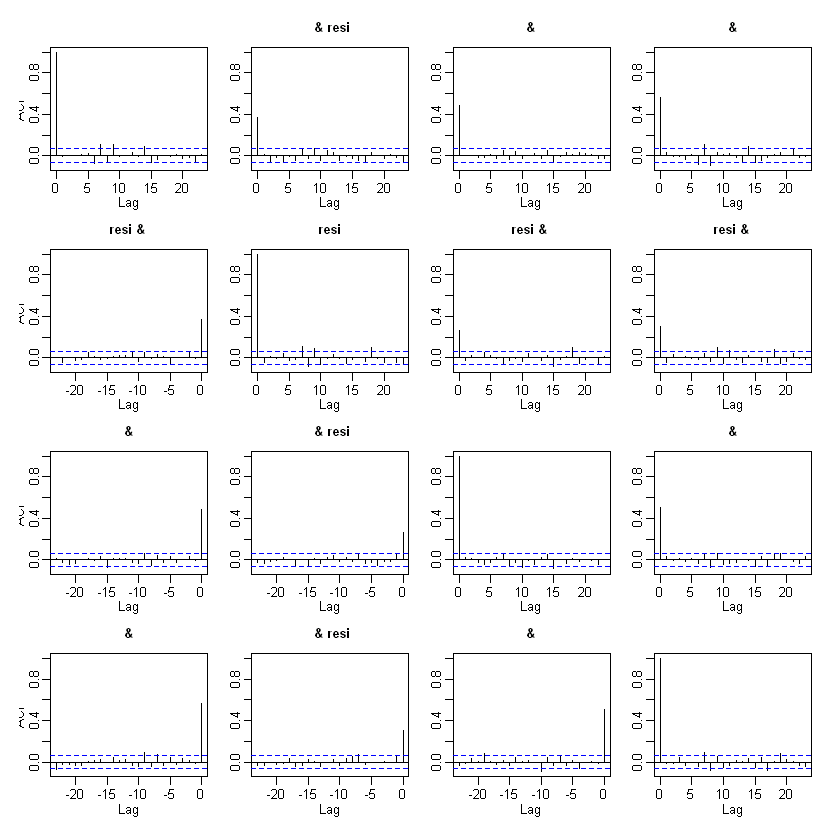

In [86]:
#Podemos igualmente visualizar los rezagos de los residuales, en búsuqueda de rezagos no capturados por el modelo.
acf(resi4)

[1] "Covariance matrix:"
          ryld.d.ts tsla.d.ts tm.d.ts gm.d.ts
ryld.d.ts    0.0692     0.799   0.296   0.161
tsla.d.ts    0.7987    65.988   4.870   2.680
tm.d.ts      0.2959     4.870   5.278   1.273
gm.d.ts      0.1614     2.680   1.273   1.187
CCM at lag:  0 
      [,1]  [,2]  [,3]  [,4]
[1,] 1.000 0.374 0.490 0.563
[2,] 0.374 1.000 0.261 0.303
[3,] 0.490 0.261 1.000 0.508
[4,] 0.563 0.303 0.508 1.000
Simplified matrix: 
CCM at lag:  1 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  2 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  3 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  4 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  5 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  6 
- . . - 
. . . . 
. . . . 
. . . . 
CCM at lag:  7 
+ + . + 
. + . . 
. . . . 
+ + . + 
CCM at lag:  8 
. . . - 
. - . . 
. . . - 
. . . - 
CCM at lag:  9 
+ + . . 
. + . + 
. . . . 
+ . . . 
CCM at lag:  10 
. . . . 
. . . . 
. . - . 
. . - . 
CCM at lag:  11 
. . . . 
. . . + 
. . . . 

Hit Enter for p-value plot of individual ccm:  


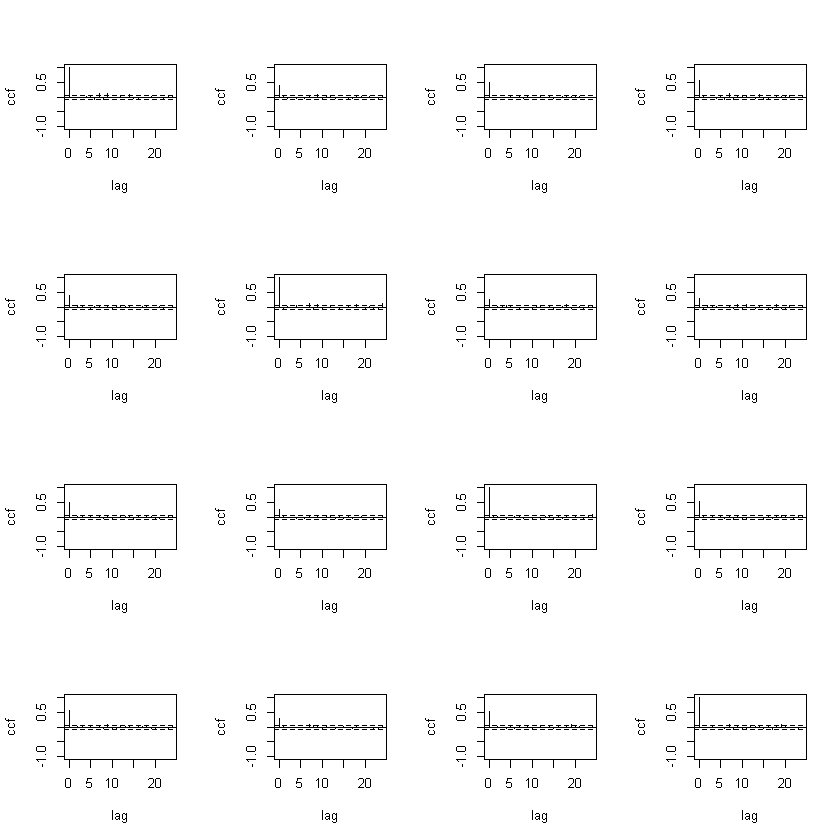

Hit Enter to compute MQ-statistics: 
Ljung-Box Statistics:  
        m       Q(m)     df    p-value
 [1,]   1.0      17.8     8.0     1.00
 [2,]   2.0      29.5    24.0     0.20
 [3,]   3.0      35.0    40.0     0.70
 [4,]   4.0      61.1    56.0     0.30
 [5,]   5.0      76.7    72.0     0.33
 [6,]   6.0      92.3    88.0     0.36
 [7,]   7.0     127.5   104.0     0.06
 [8,]   8.0     157.3   120.0     0.01
 [9,]   9.0     199.8   136.0     0.00
[10,]  10.0     216.8   152.0     0.00
[11,]  11.0     236.4   168.0     0.00
[12,]  12.0     248.0   184.0     0.00
[13,]  13.0     260.6   200.0     0.00
[14,]  14.0     284.8   216.0     0.00
[15,]  15.0     309.6   232.0     0.00
[16,]  16.0     327.2   248.0     0.00
[17,]  17.0     352.2   264.0     0.00
[18,]  18.0     373.5   280.0     0.00
[19,]  19.0     417.2   296.0     0.00
[20,]  20.0     425.9   312.0     0.00
[21,]  21.0     439.9   328.0     0.00
[22,]  22.0     452.4   344.0     0.00
[23,]  23.0     472.4   360.0     0.00
[24

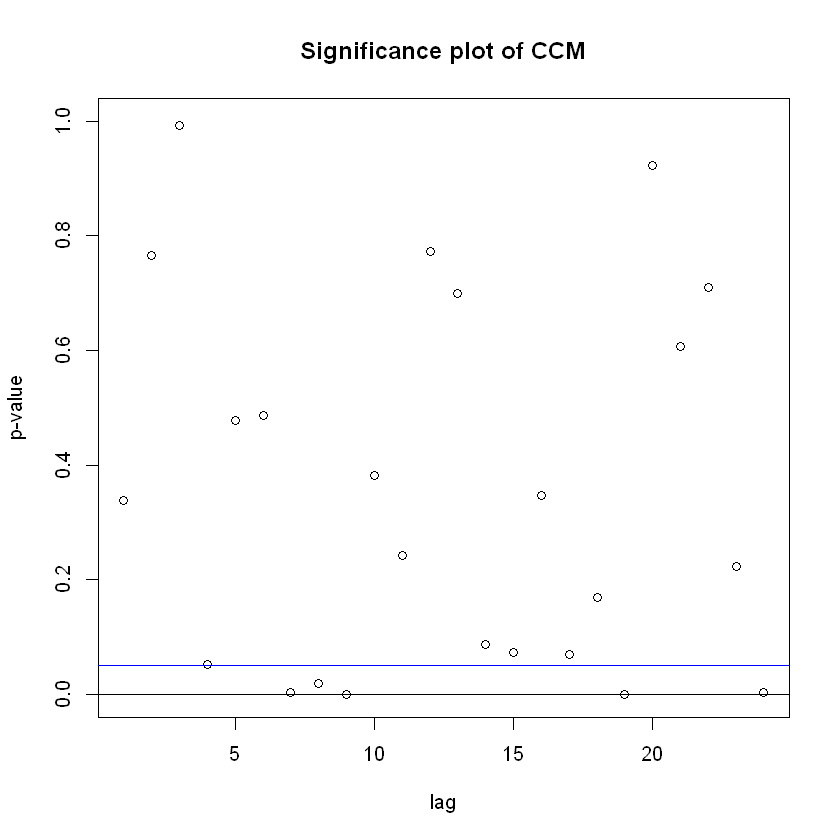

Hit Enter to obtain residual plots: 


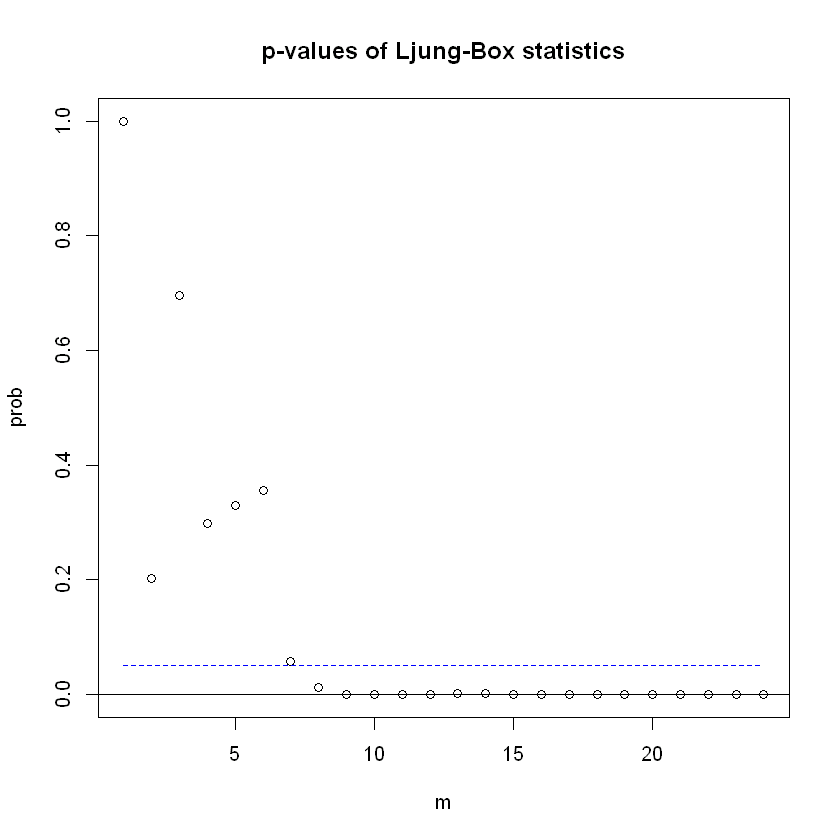

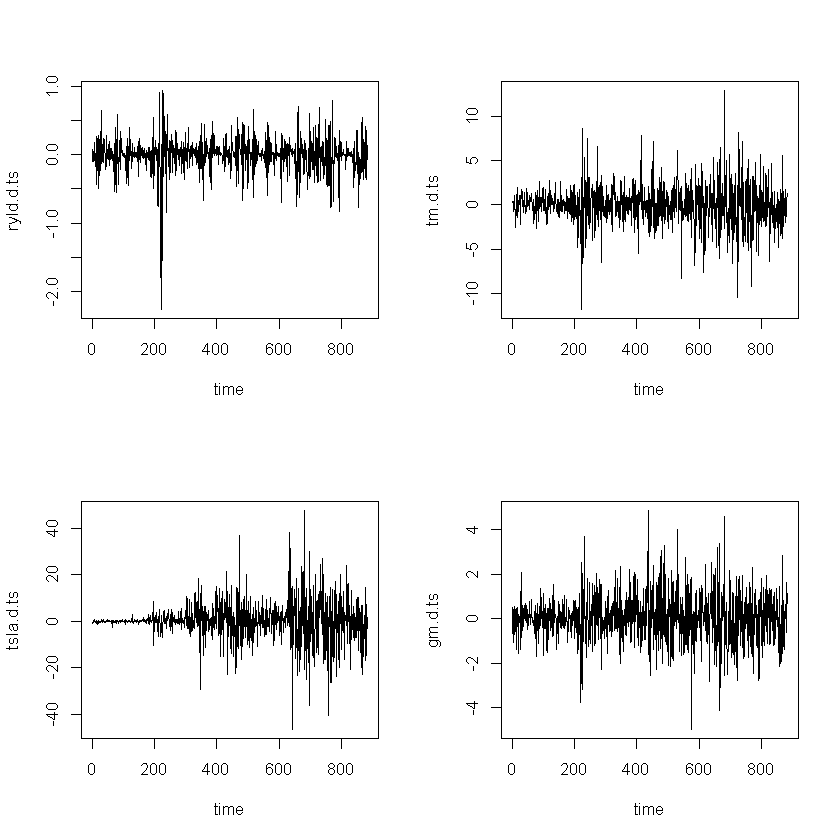

In [87]:
#Y revisamos el efecto instantáneo entre las variables:
MTSdiag(m4_mts, adj=8) 

Al revisar los p-value en CCM at lag:0, se observa que no hay valores mayores al 5% por lo que ninguna de las otras variables afecta a las otras de manera instantea

### Pronostico: Libreria MTS y series diferenciadas

In [47]:
libMTS_predtest=VARpred(m4_mts,  h=47) # Pasos a pronosticar (12)
# MTSplot(libMTS_predtest$pred)

orig  885 
Forecasts at origin:  885 
       ryld.d.ts tsla.d.ts    tm.d.ts    gm.d.ts
 [1,]  6.961e-02         0  3.564e-01  5.704e-02
 [2,] -6.868e-02         0  6.232e-02 -7.487e-02
 [3,]  2.511e-02         0  5.778e-02  1.765e-02
 [4,] -1.965e-02         0 -2.952e-02 -3.237e-02
 [5,]  8.568e-03         0  1.674e-02  8.925e-03
 [6,] -5.508e-03         0 -1.113e-02 -7.550e-03
 [7,]  2.722e-03         0  5.310e-03  3.152e-03
 [8,] -1.616e-03         0 -3.112e-03 -2.013e-03
 [9,]  8.422e-04         0  1.641e-03  1.002e-03
[10,] -4.837e-04         0 -9.127e-04 -5.961e-04
[11,]  2.582e-04         0  5.002e-04  3.100e-04
[12,] -1.456e-04         0 -2.765e-04 -1.791e-04
[13,]  7.879e-05         0  1.519e-04  9.515e-05
[14,] -4.397e-05         0 -8.396e-05 -5.387e-05
[15,]  2.398e-05         0  4.610e-05  2.906e-05
[16,] -1.330e-05         0 -2.545e-05 -1.625e-05
[17,]  7.286e-06         0  1.399e-05  8.849e-06
[18,] -4.028e-06         0 -7.715e-06 -4.913e-06
[19,]  2.212e-06         0  4.2

In [48]:
head(libMTS_predtest$pred)

ryld.d.ts,tsla.d.ts,tm.d.ts,gm.d.ts
0.069614438,0,0.35641460,0.057035468
-0.068683661,0,0.06231796,-0.074872657
0.025112369,0,0.05778499,0.017651773
-0.019649668,0,-0.02952313,-0.032370300
0.008567752,0,0.01673908,0.008924763
-0.005507661,0,-0.01113341,-0.007550225


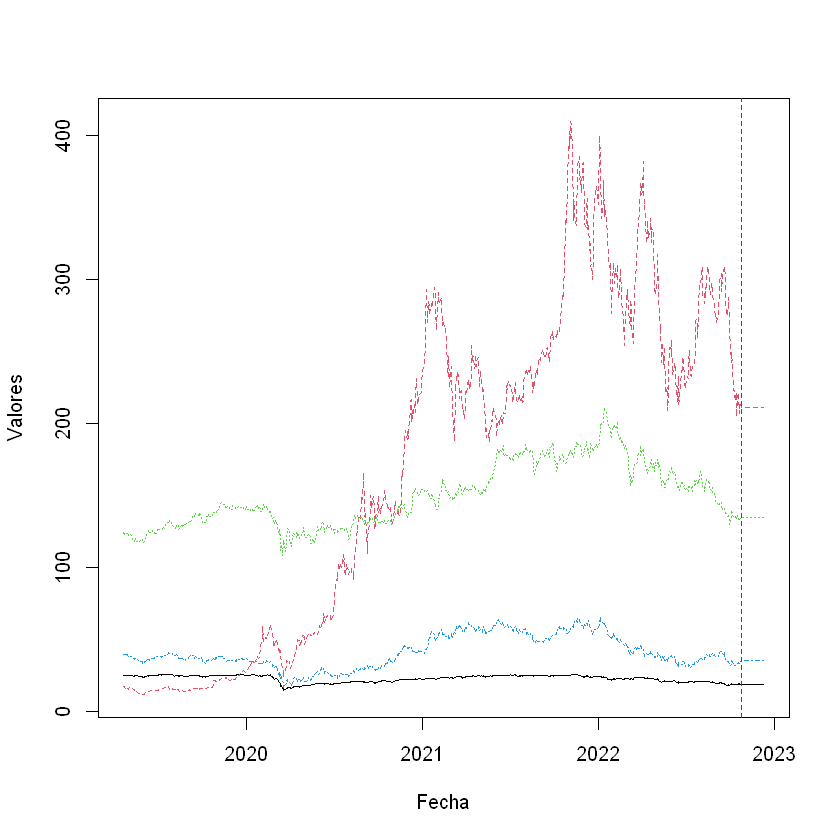

In [49]:
# Extraer las diferencias pronosticadas
diff_pred <- libMTS_predtest$pred  # matriz con diferencias pronosticadas, nrow = 46, ncol = variables

# Obtener el último nivel observado (última fila de train)
last_level <- as.numeric(tail(train, 1))

# Inicializar matriz para niveles pronosticados acumulados
level_pred <- matrix(NA, nrow = nrow(diff_pred), ncol = ncol(diff_pred))

# Primer paso: suma última observación + primera diferencia pronosticada
level_pred[1, ] <- last_level + diff_pred[1, ]

# Acumular diferencias para pasos siguientes
for (i in 2:nrow(diff_pred)) {
  level_pred[i, ] <- level_pred[i - 1, ] + diff_pred[i, ]
}

# Colocar nombres de columnas igual que en diff_pred
colnames(level_pred) <- colnames(diff_pred)

# Fecha final de la serie observada
last_date <- index(train)[nrow(train)]

# Crear vector de fechas para los valores pronosticados
forecast_dates <- seq(from = last_date + 1, by = "day", length.out = nrow(level_pred))

# Convertir matriz de predicciones a xts con fechas
level_pred_xts <- xts(level_pred, order.by = forecast_dates)
colnames(level_pred_xts) <- colnames(diff_pred)

# Combinar serie observada y serie pronosticada
full_series <- rbind(train, level_pred_xts)

# Graficar todas las series con fechas en eje x
matplot(index(full_series), coredata(full_series), type = "l", col = 1:ncol(full_series),
        xlab = "Fecha", ylab = "Valores")

# Línea vertical que separa datos observados de pronóstico
abline(v = last_date, col = "red", lty = 2)


In [50]:
# Los valores pronosticados con el nivel recuperado
head(level_pred_xts)
colnames(level_pred_xts) <- colnames(test)

           ryld.d.ts tsla.d.ts  tm.d.ts  gm.d.ts
2022-10-25  19.24961    211.25 135.0964 35.77704
2022-10-26  19.18093    211.25 135.1587 35.70216
2022-10-27  19.20604    211.25 135.2165 35.71982
2022-10-28  19.18639    211.25 135.1870 35.68745
2022-10-29  19.19496    211.25 135.2037 35.69637
2022-10-30  19.18945    211.25 135.1926 35.68882

#### Métricas de desempeño

In [51]:
rsq <- function(actual, predicted) {
  1 - sum((actual - predicted)^2) / sum((actual - mean(actual))^2)
}

variables <- colnames(level_pred_xts)  # variables pronosticadas

for (v in variables) {
  cat("Variable:", v, "\n")
  cat("MAPE:", mape(actual = test[, v], predicted = coredata(level_pred_xts)[, v]), "\n")
  cat("RMSE:", rmse(actual = test[, v], predicted = coredata(level_pred_xts)[, v]), "\n")
  cat("MAE :", mae(actual = test[, v], predicted = coredata(level_pred_xts)[, v]), "\n")
  cat("R²  :", rsq(actual = test[, v], predicted = coredata(level_pred_xts)[, v]), "\n\n")
}

Variable: RYLD 
MAPE: 0.0153113 
RMSE: 0.3298093 
MAE : 0.2968814 
R²  : -0.2629606 

Variable: TSLA 
MAPE: 0.2506452 
RMSE: 46.08219 
MAE : 37.54511 
R²  : -1.113197 

Variable: TM 
MAPE: 0.03966091 
RMSE: 6.858171 
MAE : 5.686639 
R²  : -2.022503 

Variable: GM 
MAPE: 0.07710721 
RMSE: 3.217163 
MAE : 2.975816 
R²  : -1.174796 



# VAR(8 u 7)